In my previous project, we did manual calibration assuming pinhole model. However, for real world cameras, distortions are always present to a degree. In this project we utilize OpenCV camera calibration method that deals with radial and tangential distortions.

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

I have taken multiple images of chessboard patterns that will help us come up with the camera intrisnics (See below). While any pattern is ok, as long as they provide definitive real world distances, OpenCV has implemented Chess and Checkerboard versions.

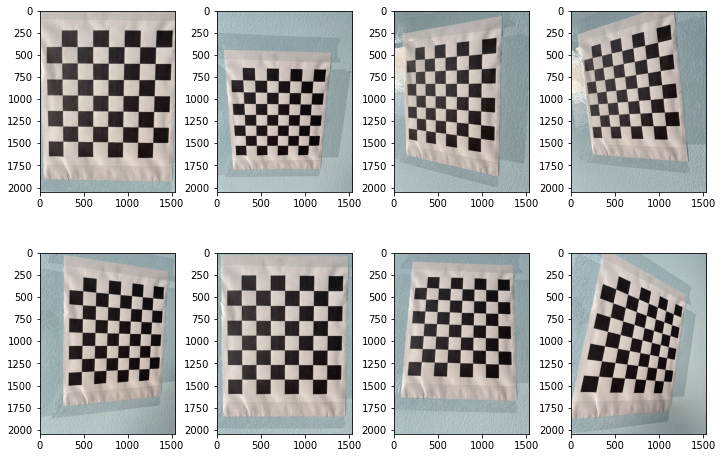

In [2]:
ff, axs = plt.subplots(2,4,figsize=(10,10))
idx=0
for fname in glob.glob('./imgs/*.JPEG')[:8]:
    gray = cv2.imread(fname)   
    plt.subplot(int("34{}".format(idx+1)))
    plt.imshow(gray)
    idx+=1
plt.tight_layout()
plt.show()

In [ ]:
The below is taken from OpenCV camera calib documentation

In [3]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

num_x = 6
num_y = 7

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((num_x*num_y,3), np.float32)
objp[:,:2] = np.mgrid[0:num_y,0:num_x].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
camdir = './imgs/'
images = glob.glob(camdir+'*.JPEG')
#images = glob.glob(camdir+'*.jpg')
i=0;

w_,h_ = (1536,2048)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (num_y,num_x), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(gray, (num_y,num_x), corners2,ret)
        cv2.imwrite('./tmp/img_'+str(i)+".jpg",img)

    i+=1;

Since I know the f in mm for my ipad. I will be using this to initialize. Line 48-61 can be commented out if this info is unavailable.

In [ ]:
f_ = 0.75
    
mtx = np.zeros((3,3),'float32')
mtx[0,0]= w_*f_
mtx[1,1]= h_*f_

mtx[0,2]= w_ * 0.5
mtx[1,2]= h_ * 0.5

mtx[2,2]= 1.0

dist = np.zeros(4,'float32')

In [ ]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w_,h_), mtx, dist )

#falgs to try 
#flags=cv2.CALIB_USE_INTRINSIC_GUESS
#cv2.CALIB_ZERO_TANGENT_DIST
#cv2.CALIB_FIX_K3 
#cv2.CALIB_FIX_PRINCIPAL_POINT 
#cv2.CALIB_FIX_ASPECT_RATIO


fx = mtx[0, 0]
fy = mtx[1, 1]

paspect = fy/fx

dim_aspect = w_*1.0/h_
img_aspect = dim_aspect * paspect

if img_aspect < 1.0:
    flen = fy / h_
else:
    flen = fx / w_

ppx = mtx[0, 2] / w_
ppy = mtx[1, 2] / h_
#ppy = mtx[0, 2] * paspect / w_

mtx2 = np.zeros((3,3),'float32')
mtx2[0,0]=  mtx[0,0]/w_
mtx2[1,1]= mtx[1,1]/h_
mtx2[0,2]= mtx[0,2]/w_
mtx2[1,2]= mtx[1,2]/h_
mtx2[2,2]= mtx[2,2]

print(mtx)
print(dist)

np.savetxt("./calib.txt", mtx)
np.savetxt("./distortions.txt", dist)

print(flen, dist[0,0], dist[1,0], paspect, ppx, ppy)
print(fx/w_ , fy/h_, ppx, ppy, dist[0,0], dist[1,0], dist[4,0], dist[2,0], dist[3,0])


mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
    
print("total error: ", mean_error/len(objpoints))


Now we have the calibration and the distortions matrices, we can save them locally

In [ ]:
# Load previously saved data
np.savetxt('./calib.txt',mtx)
np.savetxt('./distortions.txt',dist)

We can now look at the pose of the scene checkerboards since we have the camera calibation & distortion params. Below is the code to draw 3d vectors onto the 2d pattern surfaces


In [ ]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 20)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 20)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 20)
    return img

In [ ]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

idx = 0
ff, axs = plt.subplots(2,2,figsize=(10,10))
for fname in glob.glob('./imgs/*.JPEG'):
    gray = cv2.imread(fname,0)
    img = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    
    if ret == True and idx < 4:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        retval, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)
        if retval:
            # project 3D points to image plane
            imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

            img = draw(img,corners2,imgpts)
            plt.subplot(int("22{}".format(idx+1)))
            plt.imshow(img)
            idx += 1
plt.tight_layout()
plt.show()